In [44]:
# استيراد المكتبات الأساسية
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
from rasterio.plot import show
from PIL import Image


In [49]:
# تحديد المسارات الرئيسية للبيانات
jpg_folder = r"A:\soad\DEPI\EuroSAT"
tif_folder = r"A:\soad\DEPI\EuroSATallBands"

# التأكد من أن المجلدات موجودة
assert os.path.exists(jpg_folder), f"Folder exists: {jpg_folder}"
assert os.path.exists(tif_folder), f"Folder doesn't exists: {tif_folder}"

print("Folders have been successfully verified!")


Folders have been successfully verified!


In [51]:
# حساب عدد الصور في كل مجلد
num_jpg = sum(len(files) for _, _, files in os.walk(jpg_folder))
num_tif = sum(len(files) for _, _, files in os.walk(tif_folder))

print(f"Number of JPG images: {num_jpg}")
print(f"Number of TIFF images: {num_tif}")


Number of JPG images: 27003
Number of TIFF images: 27602


In [53]:
# البحث عن جميع ملفات TIFF داخل المجلدات الفرعية
tif_files = []
for root, _, files in os.walk(tif_folder):
    for file in files:
        if file.endswith(".tif"):
            tif_files.append(os.path.join(root, file))  # حفظ المسار الكامل للملف

# التأكد من وجود صور TIFF قبل المتابعة
assert len(tif_files) > 0, "No TIFF files found in the subfolders!"

# طباعة عدد الصور
print(f"Found {len(tif_files)} TIFF images.")

# قراءة أول صورة واستخدامها
with rasterio.open(tif_files[0]) as dataset:
    tif_array = dataset.read()  # تحميل جميع القنوات كمصفوفة NumPy

print(f"Loaded TIFF image: {tif_files[0]} with shape {tif_array.shape}")


Found 27597 TIFF images.
Loaded TIFF image: A:\soad\DEPI\EuroSATallBands\AnnualCrop\AnnualCrop_1.tif with shape (13, 64, 64)


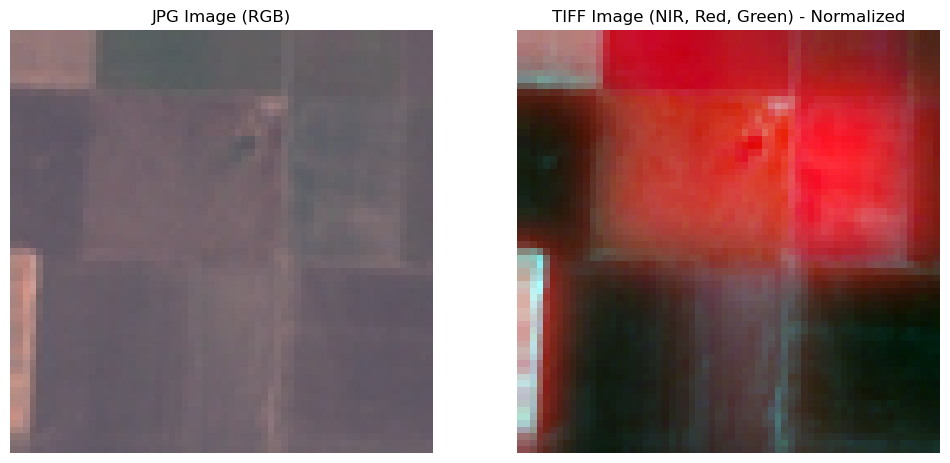

Displayed JPG image: A:\soad\DEPI\EuroSAT\AnnualCrop\AnnualCrop_1.jpg
Displayed TIFF image: A:\soad\DEPI\EuroSATallBands\AnnualCrop\AnnualCrop_1.tif


In [55]:
# تعريف دالة تطبيع القيم إلى المدى [0-1] مع التأكد من صحة القيم
def normalize_band(band):
    band = band.astype(np.float32)  # تحويل القيم إلى Float لضمان دقة العمليات الحسابية
    min_val, max_val = band.min(), band.max()
    if max_val - min_val == 0:
        return np.zeros_like(band)  # تجنب القسمة على صفر
    return (band - min_val) / (max_val - min_val)

# التأكد من وجود بيانات TIFF قبل التطبيع
assert "tif_array" in locals(), "Error: tif_array is not defined!"

# التأكد من أن الصورة تحتوي على القنوات المطلوبة
assert tif_array.shape[0] > 8, "Error: The TIFF image does not have enough bands!"

# تطبيع القنوات قبل العرض
nir_band_norm = normalize_band(tif_array[8])  # Near Infrared (NIR)
red_band_norm = normalize_band(tif_array[3])  # Red
green_band_norm = normalize_band(tif_array[2])  # Green

# دمج القنوات الثلاث لإنشاء صورة قابلة للعرض
tif_rgb = np.dstack([nir_band_norm, red_band_norm, green_band_norm])

# البحث عن أول صورة JPG في المجلد
jpg_files = []
for root, _, files in os.walk(jpg_folder):
    for file in files:
        if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".png"):
            jpg_files.append(os.path.join(root, file))

# التأكد من وجود صور JPG قبل العرض
assert len(jpg_files) > 0, "Error: No JPG images found in the subfolders!"

# تحميل أول صورة JPG
jpg_image = Image.open(jpg_files[0])

# عرض الصور
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# عرض صورة JPG
ax[0].imshow(jpg_image)
ax[0].set_title("JPG Image (RGB)")
ax[0].axis("off")

# عرض صورة TIFF بعد التطبيع
ax[1].imshow(tif_rgb)
ax[1].set_title("TIFF Image (NIR, Red, Green) - Normalized")
ax[1].axis("off")

plt.show()

# طباعة المسارات المستخدمة
print(f"Displayed JPG image: {jpg_files[0]}")
print(f"Displayed TIFF image: {tif_files[0]}")


In [57]:
# طباعة أبعاد صورة JPG
jpg_shape = np.array(jpg_image).shape
print(f"JPG Shape: {jpg_shape}, Channels: {jpg_shape[-1]}")

# طباعة أبعاد صورة TIFF
tif_shape = tif_array.shape  # (عدد القنوات، العرض، الطول)
print(f"TIFF Shape: {tif_shape}, Channels: {tif_shape[0]}")


JPG Shape: (64, 64, 3), Channels: 3
TIFF Shape: (13, 64, 64), Channels: 13


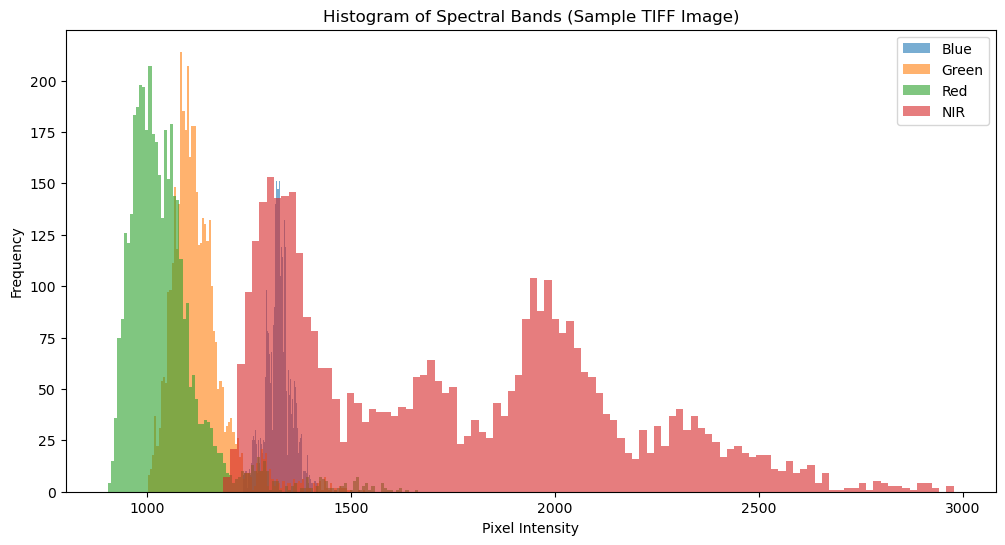

In [59]:
# اختيار 4 قنوات لعرض توزيع القيم الطيفية لها
selected_bands = [1, 2, 3, 8]  # القنوات: Blue, Green, Red, NIR
band_names = ["Blue", "Green", "Red", "NIR"]

plt.figure(figsize=(12, 6))

for i, band in enumerate(selected_bands):
    plt.hist(tif_array[band - 1].flatten(), bins=100, alpha=0.6, label=band_names[i])

plt.title("Histogram of Spectral Bands (Sample TIFF Image)")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [63]:
for i in range(tif_array.shape[0]):
    print(f"Band {i} Min: {tif_array[i].min()}, Max: {tif_array[i].max()}")


Band 0 Min: 1235, Max: 1420
Band 1 Min: 1002, Max: 1534
Band 2 Min: 905, Max: 1664
Band 3 Min: 893, Max: 2297
Band 4 Min: 1034, Max: 2128
Band 5 Min: 1120, Max: 2376
Band 6 Min: 1238, Max: 2689
Band 7 Min: 1186, Max: 2977
Band 8 Min: 353, Max: 631
Band 9 Min: 9, Max: 14
Band 10 Min: 2248, Max: 3490
Band 11 Min: 1236, Max: 2537
Band 12 Min: 1404, Max: 3108


In [65]:
nir = tif_array[7].astype(np.float32)  # بدل 8 جربي 7 أو 10
red = tif_array[3].astype(np.float32)  # الباند الأحمر ثابت


In [67]:
print("NIR Min:", nir.min(), "NIR Max:", nir.max())
print("Red Min:", red.min(), "Red Max:", red.max())


NIR Min: 1186.0 NIR Max: 2977.0
Red Min: 893.0 Red Max: 2297.0


NDVI Min: 0.07971656
NDVI Max: 0.49127445


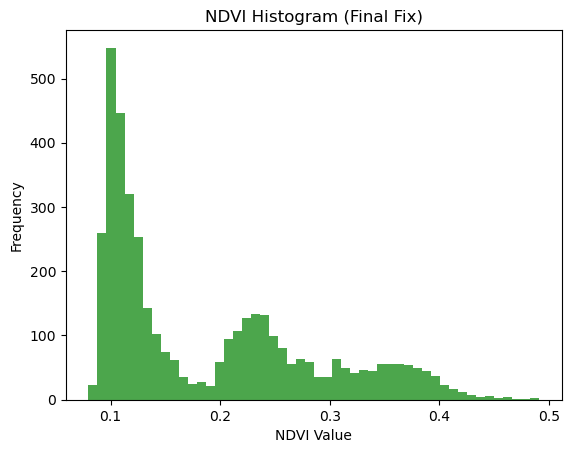

In [69]:
ndvi = (nir - red) / (nir + red + 1e-5)

print("NDVI Min:", ndvi.min())
print("NDVI Max:", ndvi.max())

plt.hist(ndvi.ravel(), bins=50, color='green', alpha=0.7)
plt.title("NDVI Histogram (Final Fix)")
plt.xlabel("NDVI Value")
plt.ylabel("Frequency")
plt.show()


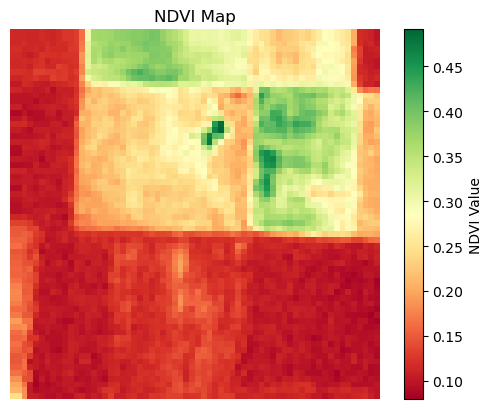

In [71]:
plt.imshow(ndvi, cmap="RdYlGn")  # الألوان: الأحمر للمناطق غير النباتية، الأخضر للنباتات
plt.colorbar(label="NDVI Value")
plt.title("NDVI Map")
plt.axis("off")
plt.show()


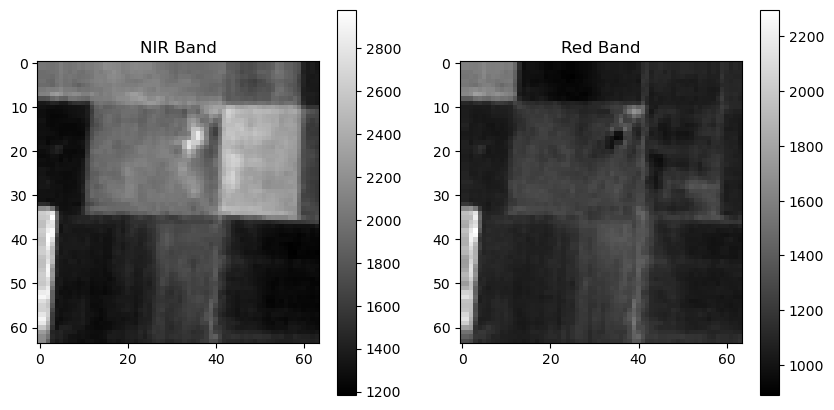

In [73]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(nir, cmap='gray')
plt.title("NIR Band")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(red, cmap='gray')
plt.title("Red Band")
plt.colorbar()

plt.show()


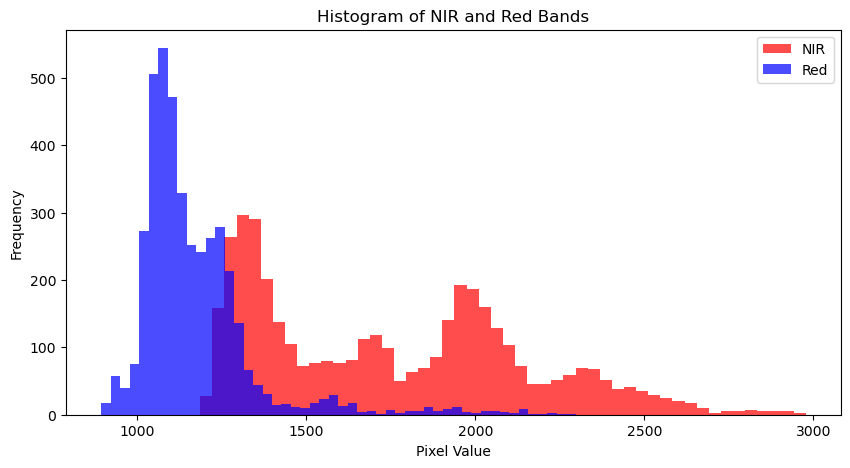

In [75]:
plt.figure(figsize=(10, 5))

plt.hist(nir.ravel(), bins=50, color='red', alpha=0.7, label='NIR')
plt.hist(red.ravel(), bins=50, color='blue', alpha=0.7, label='Red')

plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.title("Histogram of NIR and Red Bands")
plt.legend()
plt.show()


### Observations

توزيع القنوات المختلفة:

قناة NIR (الأشعة تحت الحمراء القريبة) (باللون الأحمر) تمتد عبر نطاق واسع من القيم، مما يشير إلى تفاوت كبير في الانعكاسية في هذه القناة.
قناة Red (الأحمر) (باللون الأخضر) تتركز في نطاق أضيق، مما يدل على نطاق انعكاسية محدد للمناطق التي تحتوي على هذه الأطوال الموجية.
قناة Green (الأخضر) (باللون البرتقالي) متداخلة مع الأحمر ولكنها ذات توزيع مختلف قليلاً.
قناة Blue (الأزرق) بالكاد ظاهرة، مما قد يعني أنها أقل أهمية في التمييز بين الفئات المختلفة.
الذروة والانتشار:

قنوات Red و Green و Blue تظهر ذروات متقاربة، مما يشير إلى تشابه في توزيع القيم لهذه القنوات في المشهد.
قناة NIR لها ذروتان واضحتان، مما قد يشير إلى وجود مجموعتين مختلفتين من البيانات، مثل المناطق النباتية وغير النباتية.
الفرق بين NIR والقنوات الأخرى:

قناة NIR تحتوي على توزيع أكبر مع وجود نطاق واسع من القيم، مما قد يشير إلى انعكاسية عالية للنباتات في هذه القناة.
🔹 بناءً على هذه الملاحظات، يمكن استخدام هذه البيانات في تصنيف أنواع الأراضي، حيث يمكن ملاحظة الفرق الواضح بين القنوات، وخاصةً تميز قناة NIR في الكشف عن النباتات.
    

### Observations

المناطق الخضراء الداكنة (قيم NDVI مرتفعة) تشير إلى وجود غطاء نباتي صحي وكثيف.

المناطق الصفراء الفاتحة (قيم NDVI متوسطة) قد تمثل نباتات أقل كثافة أو أراضٍ زراعية منخفضة الإنتاجية.
    
المناطق الحمراء (قيم NDVI منخفضة) تشير إلى أراضٍ غير نباتية مثل التربة العارية، المناطق العمرانية، أو المياه.
    
التوزيع غير المتجانس للألوان يدل على تنوع استخدامات الأراضي، مما يشير إلى وجود مناطق زراعية بجانب مناطق غير نباتية.
    
الحدود الواضحة بين المناطق تشير إلى احتمالية وجود حقول زراعية منظمة، مما قد يكون مفيدًا في تحليل إنتاجية المحاصيل.
📌 الخطوة التالية:

تحليل قيم NDVI رقميًا لحساب النسب المئوية لكل نوع من الأراضي.
مقارنة NDVI بفترات زمنية مختلفة لمراقبة التغيرات الموسمية.


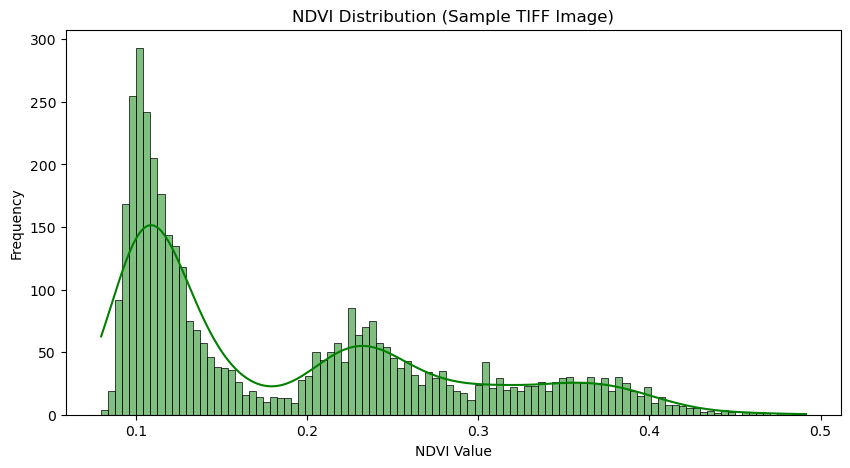

In [77]:
# رسم توزيع قيم NDVI
plt.figure(figsize=(10, 5))
sns.histplot(ndvi.flatten(), bins=100, kde=True, color="green")
plt.title("NDVI Distribution (Sample TIFF Image)")
plt.xlabel("NDVI Value")
plt.ylabel("Frequency")
plt.show()


In [79]:
# Calculate the percentage of each land cover category
total_pixels = ndvi.size

water_barren = np.sum(ndvi < 0) / total_pixels * 100  # مناطق غير نباتية (ماء/تربة مكشوفة)
low_veg = np.sum((ndvi >= 0) & (ndvi < 0.2)) / total_pixels * 100  # غطاء نباتي ضعيف
medium_veg = np.sum((ndvi >= 0.2) & (ndvi < 0.5)) / total_pixels * 100  # غطاء نباتي متوسط
high_veg = np.sum(ndvi >= 0.5) / total_pixels * 100  # غطاء نباتي كثيف

# Print the percentages
print(f"Non-vegetated areas (Water/Barren Land): {water_barren:.2f}%")
print(f"Low vegetation: {low_veg:.2f}%")
print(f"Medium vegetation: {medium_veg:.2f}%")
print(f"High vegetation: {high_veg:.2f}%")


Non-vegetated areas (Water/Barren Land): 0.00%
Low vegetation: 58.01%
Medium vegetation: 41.99%
High vegetation: 0.00%


In [81]:
print("NDVI Min:", ndvi.min(), "NDVI Max:", ndvi.max())
print(np.unique(ndvi, return_counts=True))  # نشوف توزيع القيم


NDVI Min: 0.07971656 NDVI Max: 0.49127445
(array([0.07971656, 0.08112954, 0.0832618 , ..., 0.4760772 , 0.48520556,
       0.49127445], dtype=float32), array([1, 1, 1, ..., 1, 1, 1], dtype=int64))


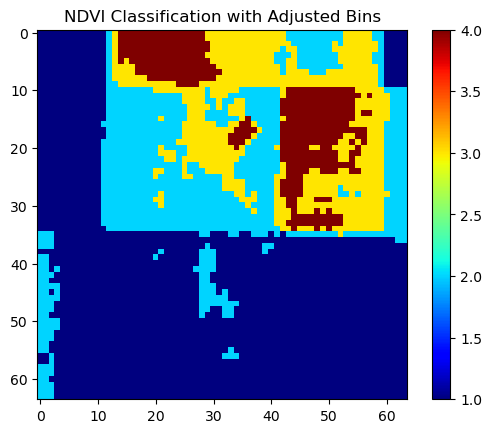

In [83]:
bins = [0.07, 0.15, 0.25, 0.35, 0.5]  # تعديل الفئات حسب القيم الفعلية
labels = [0, 1, 2, 3]  # 0 = أقل غطاء نباتي، 3 = أعلى غطاء نباتي

ndvi_classes = np.digitize(ndvi, bins, right=True)

plt.imshow(ndvi_classes, cmap='jet')  # colormap واضح للأصناف
plt.colorbar()
plt.title("NDVI Classification with Adjusted Bins")
plt.show()


### معالجة الداتا 

In [89]:
# نفترض أن لدينا بيانات الصورة متعددة القنوات tif_array
# الخطوة 1: حساب المتوسط والانحراف المعياري لكل باند
mean_values = np.mean(tif_array, axis=(1, 2))  # المتوسط لكل باند
std_values = np.std(tif_array, axis=(1, 2))    # الانحراف المعياري لكل باند

In [91]:
# طباعة القيم لمراجعتها
for i in range(tif_array.shape[0]):
    print(f"Band {i}: Mean={mean_values[i]:.2f}, Std={std_values[i]:.2f}")

Band 0: Mean=1323.20, Std=31.78
Band 1: Mean=1124.51, Std=69.51
Band 2: Mean=1044.73, Std=98.27
Band 3: Mean=1169.28, Std=173.94
Band 4: Mean=1291.63, Std=172.79
Band 5: Mean=1553.75, Std=302.14
Band 6: Mean=1765.67, Std=368.98
Band 7: Mean=1748.96, Std=396.47
Band 8: Mean=484.06, Std=79.43
Band 9: Mean=11.57, Std=0.99
Band 10: Mean=2715.40, Std=257.53
Band 11: Mean=1980.89, Std=257.59
Band 12: Mean=2030.55, Std=435.59


In [93]:
# الخطوة 2: الكشف عن القيم الشاذة (خارج 3 انحرافات معيارية عن المتوسط)
outliers = {}
for i in range(tif_array.shape[0]):
    lower_bound = mean_values[i] - 3 * std_values[i]
    upper_bound = mean_values[i] + 3 * std_values[i]
    outliers[i] = ((tif_array[i] < lower_bound) | (tif_array[i] > upper_bound)).sum()

In [95]:
# طباعة عدد القيم الشاذة في كل باند
print("\nOutliers per Band:")
for i, count in outliers.items():
    print(f"Band {i}: {count} pixels")


Outliers per Band:
Band 0: 6 pixels
Band 1: 86 pixels
Band 2: 95 pixels
Band 3: 100 pixels
Band 4: 87 pixels
Band 5: 0 pixels
Band 6: 0 pixels
Band 7: 3 pixels
Band 8: 0 pixels
Band 9: 0 pixels
Band 10: 2 pixels
Band 11: 0 pixels
Band 12: 0 pixels


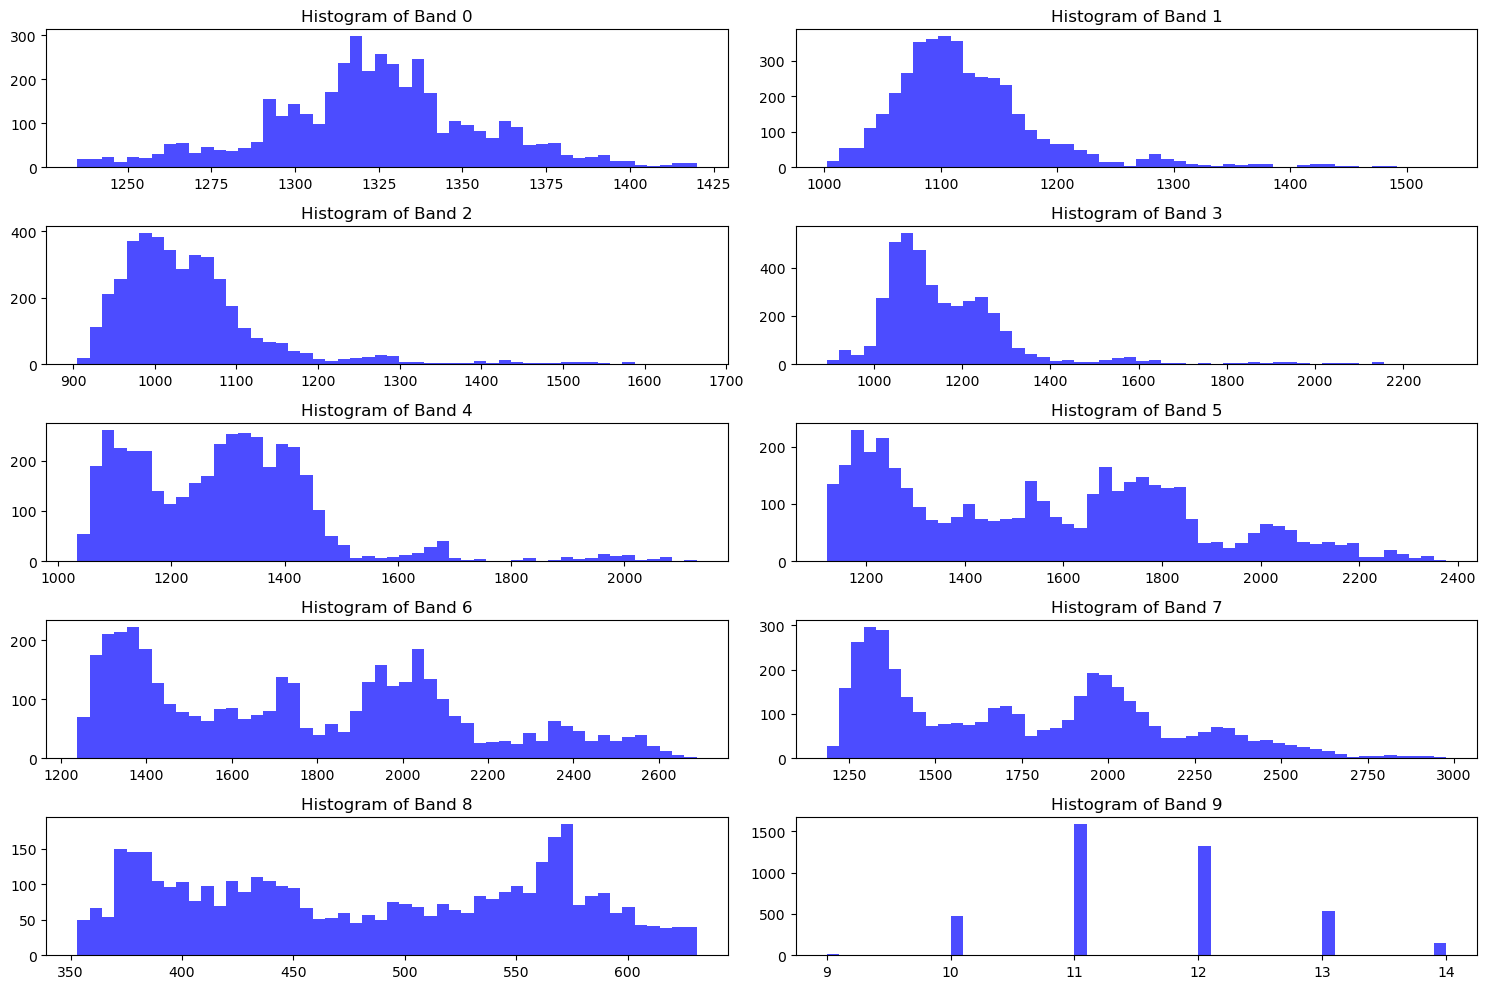

In [97]:
# الخطوة 3: رسم هيستوجرام لكل باند لرؤية توزيع البيانات
plt.figure(figsize=(15, 10))
for i in range(min(10, tif_array.shape[0])):  # نعرض أول 10 باندات فقط
    plt.subplot(5, 2, i+1)
    plt.hist(tif_array[i].ravel(), bins=50, alpha=0.7, color='b')
    plt.title(f"Histogram of Band {i}")
plt.tight_layout()
plt.show()


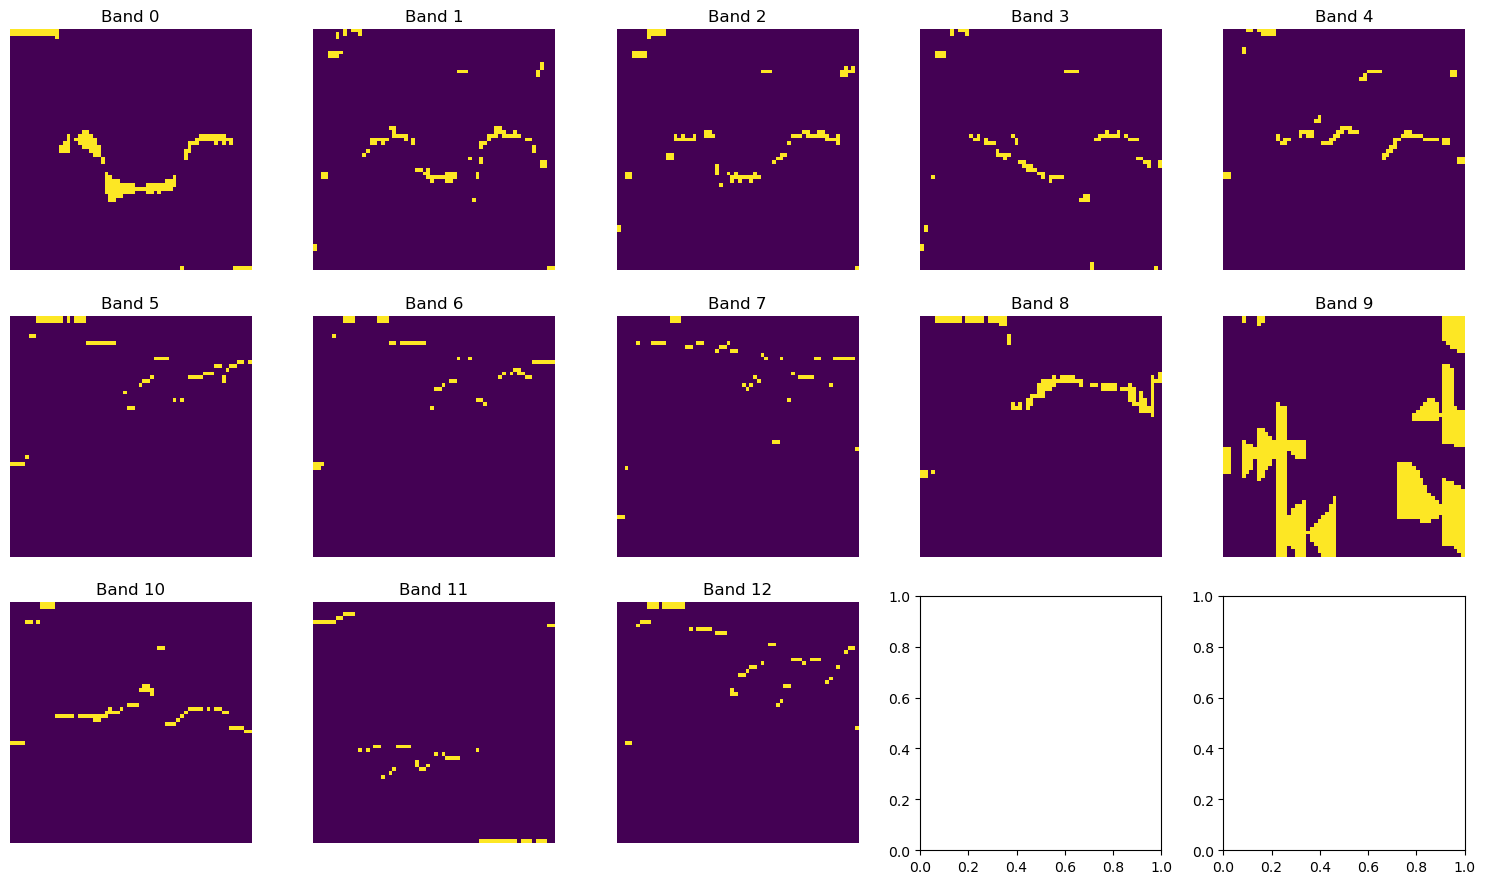

In [132]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
from sklearn.preprocessing import MinMaxScaler

# 1. تطبيق Median Filter على الـ Bands اللي فيها قيم شاذة
tif_array_filtered = np.zeros_like(tif_array)
for i in range(tif_array.shape[0]):
    if i in [1, 2, 3, 4]:  # تطبيق الفلتر فقط على الـ Bands اللي فيها قيم شاذة
        tif_array_filtered[i] = median_filter(tif_array[i], size=3)
    else:
        tif_array_filtered[i] = tif_array[i]  # نستخدم القيم الأصلية للـ Bands التانية

# 2. تدرج البيانات
tif_array_scaled = np.zeros_like(tif_array_filtered)
for i in range(tif_array_filtered.shape[0]):
    band = tif_array_filtered[i]
    scaler = MinMaxScaler(feature_range=(0, 1))
    tif_array_scaled[i] = scaler.fit_transform(band)

# 3. عرض الصور
fig, axes = plt.subplots(3, 5, figsize=(15, 9))  # 3 صفوف و 5 أعمدة (حسب عدد الباندات)
axes = axes.flatten()

for i in range(min(13, len(axes))):  # عرض 13 باند فقط
    axes[i].imshow(tif_array_scaled[i], cmap='viridis')  # استخدام cmap مختلفة
    axes[i].set_title(f'Band {i}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

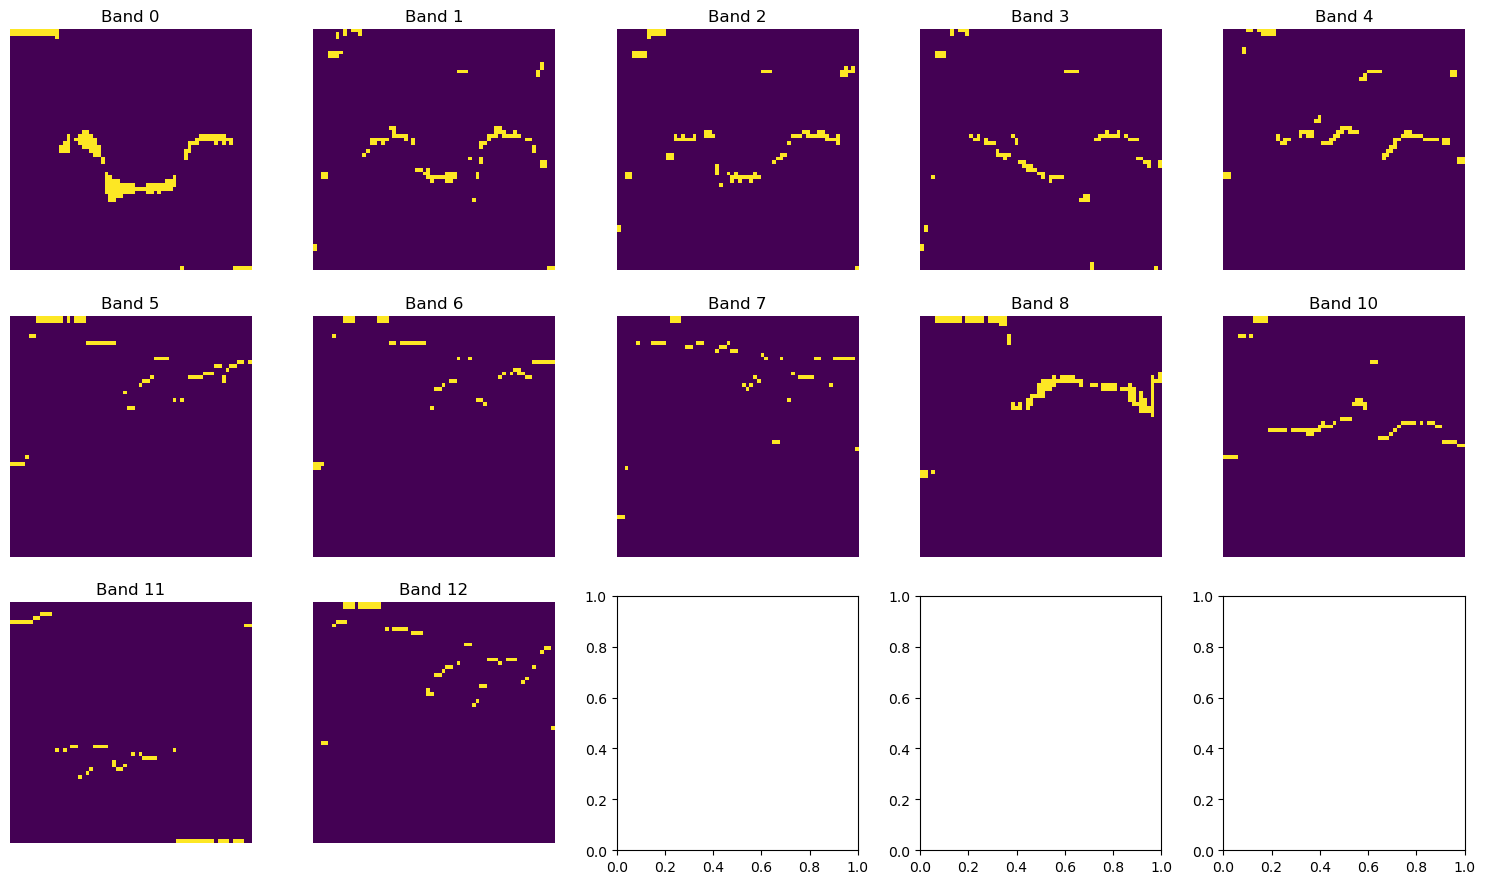

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
from sklearn.preprocessing import MinMaxScaler

# 1. تطبيق Median Filter على الـ Bands اللي فيها قيم شاذة
tif_array_filtered = np.zeros_like(tif_array)
for i in range(tif_array.shape[0]):
    if i in [1, 2, 3, 4]:  # تطبيق الفلتر فقط على الـ Bands اللي فيها قيم شاذة
        tif_array_filtered[i] = median_filter(tif_array[i], size=3)
    else:
        tif_array_filtered[i] = tif_array[i]  # نستخدم القيم الأصلية للـ Bands التانية

# 2. تدرج البيانات
tif_array_scaled = np.zeros_like(tif_array_filtered)
for i in range(tif_array_filtered.shape[0]):
    band = tif_array_filtered[i]
    scaler = MinMaxScaler(feature_range=(0, 1))
    tif_array_scaled[i] = scaler.fit_transform(band)

# 3. عرض الصور (نتخطى Band 9)
fig, axes = plt.subplots(3, 5, figsize=(15, 9))  # 3 صفوف و 5 أعمدة (حسب عدد الباندات)
axes = axes.flatten()

band_index = 0  # عداد علشان نتحكم في ترتيب الـ Bands
for i in range(tif_array_scaled.shape[0]):
    if i == 9:  # نتخطى Band 9
        continue
    axes[band_index].imshow(tif_array_scaled[i], cmap='viridis')  # استخدام cmap مختلفة
    axes[band_index].set_title(f'Band {i}')
    axes[band_index].axis('off')
    band_index += 1
    if band_index >= len(axes):  # نتوقف لو وصلنا لعدد الـ subplots المتاحة
        break

plt.tight_layout()
plt.show()

In [99]:
normalized_bands = (tif_array - tif_array.min(axis=(1,2), keepdims=True)) / \
                   (tif_array.max(axis=(1,2), keepdims=True) - tif_array.min(axis=(1,2), keepdims=True))

print("✅ تم التطبيع: جميع القيم الآن بين 0 و 1")

✅ تم التطبيع: جميع القيم الآن بين 0 و 1


In [146]:
import numpy as np
from scipy.ndimage import median_filter

# افترضنا إن tif_array معرّفة مسبقًا (مثلاً: شكلها (3, 256, 256))

# 1. حساب الانحراف المعياري لكل band
std_dev = np.std(tif_array, axis=(1, 2))  # الانحراف المعياري لكل band
mean = np.mean(tif_array, axis=(1, 2))  # المتوسط لكل band

# 2. تحديد القيم الشاذة (Outliers)
# نعتبر أي قيمة خارج نطاق [mean - 3*std_dev, mean + 3*std_dev] قيم شاذة
outliers_mask = (tif_array < mean[:, None, None] - 3 * std_dev[:, None, None]) | \
                (tif_array > mean[:, None, None] + 3 * std_dev[:, None, None])

# 3. تطبيق Median Filter على القيم الشاذة
filtered_bands = np.where(
    outliers_mask,  # الشرط: القيم الشاذة
    median_filter(tif_array, size=(1, 3, 3)),  # القيم الجديدة (بعد التصفية)
    tif_array  # القيم الأصلية (لو الشرط مش متحقق)
)

print(" تم تصحيح القيم الشاذة باستخدام Median Filter")

 تم تصحيح القيم الشاذة باستخدام Median Filter


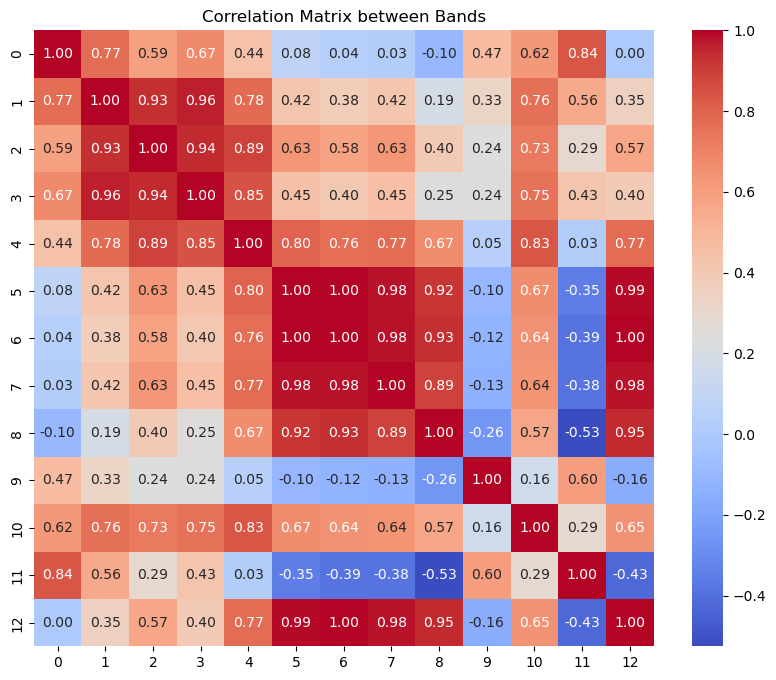

In [105]:
# الخطوة 4: حساب معامل الارتباط بين الباندات
band_reshaped = tif_array.reshape(tif_array.shape[0], -1)  # تحويل الأبعاد لحساب الارتباط
correlation_matrix = np.corrcoef(band_reshaped)

# رسم خريطة الارتباط بين الباندات
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=range(tif_array.shape[0]), yticklabels=range(tif_array.shape[0]))
plt.title("Correlation Matrix between Bands")
plt.show()


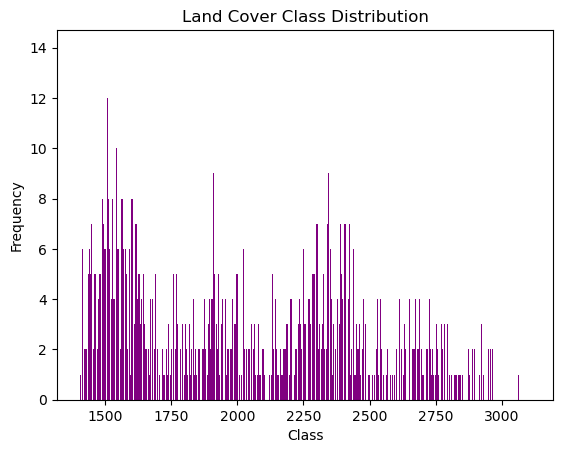

In [107]:
land_cover_labels = tif_array[-1].astype(int)

labels, counts = np.unique(land_cover_labels, return_counts=True)
plt.bar(labels, counts, color="purple")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.title("Land Cover Class Distribution")
plt.show()


In [154]:
import numpy as np
from sklearn.model_selection import train_test_split

# 1. تحضير البيانات
X = tif_array_scaled  # البيانات بعد التنظيف والتدرج
y = labels  # التصنيفات (Labels) - لازم تكون معرّفة مسبقًا

# 2. تأكد من شكل البيانات
print("Shape of X before reshape:", X.shape)
print("Shape of y:", y.shape)

# 3. إعادة تشكيل البيانات (Reshape)
# نفرض إن X شكلها (13, height, width) - 13 band وكل band عبارة عن صورة
X = X.reshape(X.shape[0], -1)  # نحول كل صورة لـ 1D array
print("Shape of X after reshape:", X.shape)

# 4. تقسيم البيانات إلى Training Set و Testing Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("✅ تم تقسيم البيانات بنجاح")
print(f"عدد عينات التدريب: {X_train.shape[0]}")
print(f"عدد عينات الاختبار: {X_test.shape[0]}")

Shape of X before reshape: (13, 64, 64)
Shape of y: (1297,)
Shape of X after reshape: (13, 4096)


ValueError: Found input variables with inconsistent numbers of samples: [13, 1297]